In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd #a library to make the data more structured55r56y6y

In [2]:
df = pd.read_csv('data/text-preprocessing.csv')
df = df.drop(columns=['Unnamed: 0'])

In [3]:
df.shape

(109705, 23)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109705 entries, 0 to 109704
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   tweet_id                     109705 non-null  int64  
 1   author_name                  109705 non-null  object 
 2   author_username              109705 non-null  object 
 3   author_location              78272 non-null   object 
 4   content                      109705 non-null  object 
 5   content_clean                109437 non-null  object 
 6   like_count                   109604 non-null  float64
 7   retweet_count                17012 non-null   float64
 8   reply_count                  16620 non-null   float64
 9   source                       109705 non-null  object 
 10  keyword                      109705 non-null  object 
 11  address                      64928 non-null   object 
 12  longitude                    66438 non-null   float64
 13 

In [5]:
df_new = df[df['tweet_tokens_stemmed_string'].notnull()]

In [6]:
df_new['tweet_tokens_stemmed_string'].head()

0    lomba poster ilmiah energi baru deadline janua...
1                 elaahhh ngomong energi baru tv biruu
2    daerah pencil membutuhkam listrik manfaat ener...
3    tarik materi energi baru baek ganti nama propa...
4    aneh inget jatropa alias minyak jarak bbrp jat...
Name: tweet_tokens_stemmed_string, dtype: object

In [7]:
#lower text
# ------ Case Folding --------
# gunakan fungsi Series.str.lower() pada Pandas
df_new['tweet_tokens_stemmed_string'] = df_new['tweet_tokens_stemmed_string'].str.lower()


print('Case Folding Result : \n')
print(df_new['tweet_tokens_stemmed_string'].head(5))


Case Folding Result : 

0    lomba poster ilmiah energi baru deadline janua...
1                 elaahhh ngomong energi baru tv biruu
2    daerah pencil membutuhkam listrik manfaat ener...
3    tarik materi energi baru baek ganti nama propa...
4    aneh inget jatropa alias minyak jarak bbrp jat...
Name: tweet_tokens_stemmed_string, dtype: object


In [8]:
text = df_new['tweet_tokens_stemmed_string']
text_list =  [i.split() for i in text]
#text_list =  [i for i in text]
print(len(text_list))

109404


In [9]:
#masi salah hasil frekuensi nya
# NLTK calc frequency distribution
from nltk.probability import FreqDist
def freqDist_wrapper(text):
    return FreqDist(text)

df_new['tweet_tokens_stemmed_string'] = df_new['tweet_tokens_stemmed_string'].apply(freqDist_wrapper)

print('Frequency Tokens : \n') 
df_new['tweet_tokens_stemmed_string'].head().apply(lambda x : x.most_common())

Frequency Tokens : 



0    [( , 11), (a, 10), (e, 6), (i, 6), (s, 5), (r,...
1    [( , 5), (e, 3), (a, 3), (h, 3), (n, 3), (g, 3...
2    [(a, 7), ( , 6), (e, 5), (r, 4), (i, 4), (m, 4...
3    [(a, 10), ( , 8), (r, 5), (i, 5), (e, 4), (t, ...
4    [(a, 12), ( , 12), (r, 8), (e, 7), (b, 6), (i,...
Name: tweet_tokens_stemmed_string, dtype: object

In [10]:
#https://sites.unpad.ac.id/widodo/2021/03/09/nlp-dengan-python/

In [11]:
import gensim
#Create Bigram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(text_list, min_count=10)
trigram = Phrases(bigram[text_list])
for idx in range(len(text_list)):
    for token in bigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)
    for token in trigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)

In [12]:
from gensim import corpora, models
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(text_list)
dictionary.filter_extremes(no_below=5, no_above=0.2) 
#no_below (int, optional) – Keep tokens which are contained in at least no_below documents.
#no_above (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
print(dictionary)

Dictionary<16354 unique tokens: ['deadline', 'derajat', 'ilmiah', 'januari', 'lomba']...>


In [13]:
#https://radimrehurek.com/gensim/tut1.html 
#build corpus
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
#The function doc2bow converts document (a list of words) into the bag-of-words format
'''The function doc2bow() simply counts the number of occurrences of each distinct word, 
converts the word to its integer word id and returns the result as a sparse vector. 
The sparse vector [(0, 1), (1, 1)] therefore reads: in the document “Human computer interaction”, 
the words computer (id 0) and human (id 1) appear once; 
the other ten dictionary words appear (implicitly) zero times.'''
print(len(doc_term_matrix))
print(doc_term_matrix[100])
tfidf = models.TfidfModel(doc_term_matrix) #build TF-IDF model
corpus_tfidf = tfidf[doc_term_matrix]

109404
[(35, 1), (188, 1)]


In [14]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=100, random_state=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

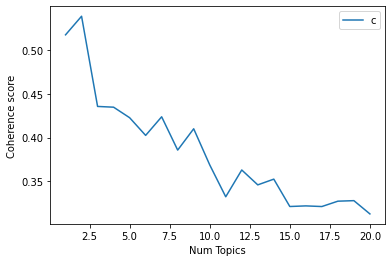

In [15]:
start=1
limit=21
step=1
model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus_tfidf, 
                                                        texts=text_list, start=start, limit=limit, step=step)
#show graphs
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 1  has Coherence Value of 0.517
Num Topics = 2  has Coherence Value of 0.539
Num Topics = 3  has Coherence Value of 0.436
Num Topics = 4  has Coherence Value of 0.435
Num Topics = 5  has Coherence Value of 0.423
Num Topics = 6  has Coherence Value of 0.402
Num Topics = 7  has Coherence Value of 0.424
Num Topics = 8  has Coherence Value of 0.386
Num Topics = 9  has Coherence Value of 0.41
Num Topics = 10  has Coherence Value of 0.369
Num Topics = 11  has Coherence Value of 0.332
Num Topics = 12  has Coherence Value of 0.363
Num Topics = 13  has Coherence Value of 0.346
Num Topics = 14  has Coherence Value of 0.352
Num Topics = 15  has Coherence Value of 0.321
Num Topics = 16  has Coherence Value of 0.322
Num Topics = 17  has Coherence Value of 0.321
Num Topics = 18  has Coherence Value of 0.327
Num Topics = 19  has Coherence Value of 0.328
Num Topics = 20  has Coherence Value of 0.313


In [17]:
model = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=2, random_state=1) #num topic menyesuaikan hasil dari coherence value paling tinggi

In [18]:
for idx, topic in model.print_topics():
    print('Topic: {} Word: {}'.format(idx+1, topic))
    # yg belum remove Yang, yg,trus lower text

Topic: 1 Word: 0.013*"pln" + 0.013*"pln_id" + 0.009*"kembang" + 0.008*"bangkit_listrik" + 0.008*"indonesia" + 0.008*"bangkit" + 0.008*"listrik" + 0.006*"menteri_esdm" + 0.006*"target" + 0.006*"capai_target"
Topic: 2 Word: 0.010*"ruu" + 0.008*"erick_thohir" + 0.005*"menteri_bumn" + 0.005*"tinggi_indonesia" + 0.005*"larang_ekspor" + 0.004*"erick" + 0.004*"capai_persen" + 0.004*"kuat_bidang" + 0.004*"thohir" + 0.004*"mobil_listrik"


In [19]:
for i in range(0, model.num_topics):
    print(i+1,model.print_topic(i), "\n")

1 0.013*"pln" + 0.013*"pln_id" + 0.009*"kembang" + 0.008*"bangkit_listrik" + 0.008*"indonesia" + 0.008*"bangkit" + 0.008*"listrik" + 0.006*"menteri_esdm" + 0.006*"target" + 0.006*"capai_target" 

2 0.010*"ruu" + 0.008*"erick_thohir" + 0.005*"menteri_bumn" + 0.005*"tinggi_indonesia" + 0.005*"larang_ekspor" + 0.004*"erick" + 0.004*"capai_persen" + 0.004*"kuat_bidang" + 0.004*"thohir" + 0.004*"mobil_listrik" 



In [20]:
import pandas as pd
top_words_per_topic = []
for t in range(model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in model.show_topic(t, topn = 5)]) #ubah2 yg ini
# df=pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words_topic_20.csv")
df = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word','P']).to_excel("data/lda_model_topic_2.xlsx")
print(df)


None


In [21]:
#ini dilakukan jika module belum tersedia
!pip install pyLDAvis
#!apt-get -qq install -y pyLDAvis

In [22]:
#import gensim
import pyLDAvis
import pyLDAvis.gensim_models;pyLDAvis.enable_notebook()
data = pyLDAvis.gensim_models.prepare(model, corpus_tfidf, dictionary)
print(data)
pyLDAvis.save_html(data, 'data/lda-gensim_clean_kualitatif2.html')

/Users/indralionardy/Personal/sara/tugas-akhir/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/indralionardy/Personal/sara/tugas-akhir/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/indralionardy/Personal/sara/tugas-akhir/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/indralionardy/Personal/sara/tugas-akhir/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
 

PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
0      0.20292  0.0       1        1  59.021414
1     -0.20292  0.0       2        1  40.978586, topic_info=                  Term         Freq        Total Category  logprob  loglift
7140            pln_id  2083.000000  2083.000000  Default  30.0000  30.0000
150                pln  2100.000000  2100.000000  Default  29.0000  29.0000
8163      erick_thohir   938.000000   938.000000  Default  28.0000  28.0000
3362               ruu  1115.000000  1115.000000  Default  27.0000  27.0000
783    bangkit_listrik  1345.000000  1345.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
16340  inggris_sepakat   311.870154   358.588195   Topic2  -5.8778   0.7525
5179          sulawesi   294.871302   343.430303   Topic2  -5.9338   0.7397
245                dpr   276.461055   318.716112   Topic2  -5.9983   0.7499
16195

In [23]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
panel = gensimvis.prepare(model, corpus_tfidf, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  59.021406
1      60.312561 -141.369141       2        1  40.978594, topic_info=                  Term         Freq        Total Category  logprob  loglift
7140            pln_id  2083.000000  2083.000000  Default  30.0000  30.0000
150                pln  2100.000000  2100.000000  Default  29.0000  29.0000
8163      erick_thohir   938.000000   938.000000  Default  28.0000  28.0000
3362               ruu  1115.000000  1115.000000  Default  27.0000  27.0000
783    bangkit_listrik  1345.000000  1345.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
16340  inggris_sepakat   311.870217   358.588251   Topic2  -5.8778   0.7525
5179          sulawesi   294.871361   343.430355   Topic2  -5.9338   0.7397
245                dpr   276.461111   318.716161   Topic2  -5.9983   0.7499
16195      simak_bawah   328.174470   441.220934   Topic2  -5.8268   0.5961
169              bahas   244.421813   358.309279   Topic2  -6.1215   0.5096

[141 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
1323       1  0.016215           airlangga
1323       2  0.985090           airlangga
9086       1  0.010566  airlangga_hartarto
9086       2  0.993208  airlangga_hartarto
11837      2  1.000375                 ako
...      ...       ...                 ...
1049       1  0.035712                  uu
1049       2  0.964227                  uu
658        2  0.998148                 vii
10521      1  0.073292          yantie_pln
10521      2  0.926414          yantie_pln

[216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])